# Basic example: choose a car

First we configure the notebook so we can plot figures (first line), and also we have autocompletion.

In [1]:
%matplotlib inline
%config Completer.use_jedi = False

## Problem formalization

The beginning of all problem resolution is to formalize the problem.
In Multi-Criteria Decision Analysis, one such problem can consist of choosing one alternative among a set.

In [2]:
alternatives = ["Fiat 500", "Peugeot 309", "Renault Clio", "Opel Astra", "Honda Civic", "Toyota Corolla"]

We can list criteria that are considered relevant to make that choice:

In [3]:
criteria = ["cost", "fuel consumption", "comfort", "color", "range"]

Those criteria can have different types of scales associated to them and are in general heterogeneous:
* The cost in euros is to be minimized
* The fuel consumption in L/100km is to be minimized
* The comfort can be rated with stars, and must be maximized
* The color is way more subjective and can be associated to a ranking (here the decider prefers red cars and hates grey ones)
* The range is in km and must be maximized

We must therefore enter the limits of those scales for the current MCDA problem and associate non-numeric criteria values to numeric values if we want to make computations later on.

In [4]:
from mcda import PerformanceTable
from mcda.scales import *

In [5]:
scale1 = QuantitativeScale(6000, 20000, preference_direction=MIN)
scale2 = QuantitativeScale(4, 6, preference_direction=MIN)
scale3 = QualitativeScale({"*": 1, "**": 2, "***": 3, "****": 4})
scale4 = QualitativeScale(
    {"red": 1, "blue": 2, "black": 3, "grey": 4},
    preference_direction=MIN
)
scale5 = QuantitativeScale(400, 1000)
scales = {
    criteria[0]: scale1,
    criteria[1]: scale2,
    criteria[2]: scale3,
    criteria[3]: scale4,
    criteria[4]: scale5
}

Then we can gather the data for each alternative and criterion in a performance table:

In [6]:
performance_table = PerformanceTable(
    [
        [9500, 4.2, "**", "blue", 450],
        [15600, 4.5, "****", "black", 900],
        [6800, 4.1, "***", "grey", 700],
        [10200, 5.6, "****", "black", 850],
        [8100, 5.2, "***", "red", 750],
        [12000, 4.9, "****", "grey", 850]
    ],
    alternatives=alternatives,
    criteria=criteria,
    scales=scales,
)
performance_table.data

cost  fuel consumption comfort  color  range
Fiat 500         9500               4.2      **   blue    450
Peugeot 309     15600               4.5    ****  black    900
Renault Clio     6800               4.1     ***   grey    700
Opel Astra      10200               5.6    ****  black    850
Honda Civic      8100               5.2     ***    red    750
Toyota Corolla  12000               4.9    ****   grey    850

To orient the decision process, it is important to visualize the data on which we will base the decision: the performance table

In [7]:
from mcda.plot import *

/home/nduminy/pymcda/src/mcda/internal/plot/plot.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


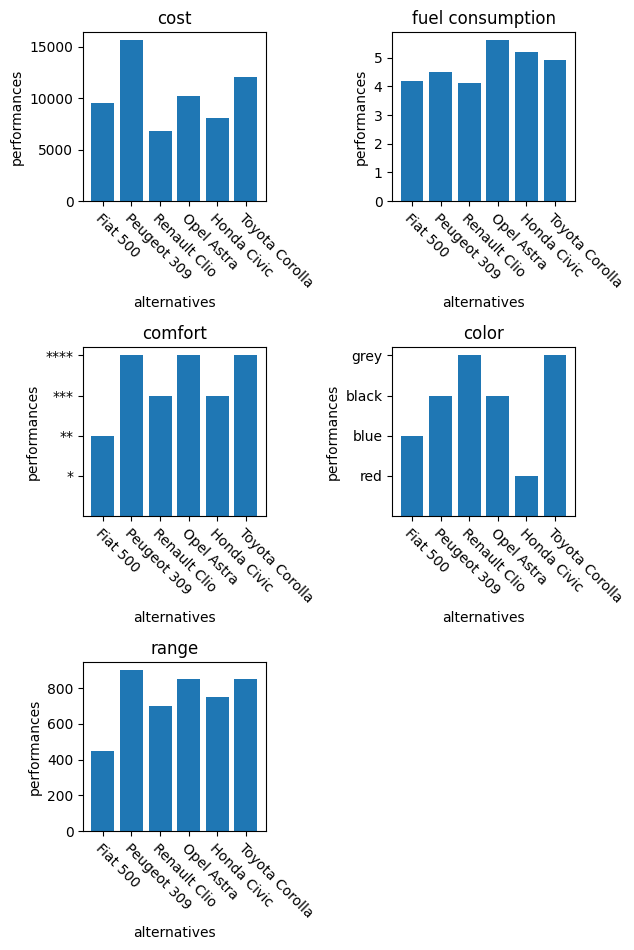

In [8]:
fig = Figure(ncols=2, figsize=(6.4, 9.6))

x = [*range(len(alternatives))]
xticks = x
xticklabels = alternatives
for i in criteria:
    values = performance_table.criteria_values[i].data
    ax = fig.create_add_axis()
    ax.title = i
    ax.xlabel = "alternatives"
    ax.ylabel = "performances"
    yticks = None
    yticklabels = None
    y = values
    if isinstance(scales[i], QualitativeScale):
        y = [scales[i].value(v) for v in values]
        yticklabels = scales[i].range()
        yticks = [
            scales[i].value(yy) for yy in yticklabels
        ]
    elif isinstance(scales[i], NominalScale):
        yticklabels = scales[i].range()
        yticks = [*range(len(yticklabels))]
        y = [yticks[yticklabels.index(v)] for v in values]
    ax.add_plot(
        BarPlot(
            x,
            y,
            xticks=xticks,
            yticks=yticks,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            xticklabels_tilted=True
        )
    )
fig.draw()

It is quite difficult to take a decision solely based on this graph, we can therefore start a multistep decision process.

## Decision process

We can easily check that not all performances from our performance table are numeric, which makes them hard to compare:

In [9]:
performance_table.is_numeric

False

To compare those performances, we can transform them all to numeric values.
We could use the `mcda.transformers` module for that, however a simple conversion to numeric values
is direcly possible through the `PerformanceTable` `to_numeric` property:

In [10]:
performance_table.to_numeric.data

cost  fuel consumption  comfort  color  range
Fiat 500         9500               4.2        2      2    450
Peugeot 309     15600               4.5        4      3    900
Renault Clio     6800               4.1        3      4    700
Opel Astra      10200               5.6        4      3    850
Honda Civic      8100               5.2        3      1    750
Toyota Corolla  12000               4.9        4      4    850

However the ranges of those numerical values still varies wildly.
Furthermore their preference direction may also differ.
In other words, we need to normalize them.

The scales contain all information necessary for this operation, they contain also the preferrence order of each criterion (ex: cost must be minimized, range maximized, etc). This way we can also perform the normalization so that normalized criteria values are all in increasing order:

In [11]:
from mcda import normalize

In [12]:
normalized_table = normalize(performance_table)
normalized_table.data

cost  fuel consumption   comfort     color     range
Fiat 500        0.750000              0.90  0.333333  0.666667  0.083333
Peugeot 309     0.314286              0.75  1.000000  0.333333  0.833333
Renault Clio    0.942857              0.95  0.666667  0.000000  0.500000
Opel Astra      0.700000              0.20  1.000000  0.333333  0.750000
Honda Civic     0.850000              0.40  0.666667  1.000000  0.583333
Toyota Corolla  0.571429              0.55  1.000000  0.000000  0.750000

Radar or spider plot are then a very good way to visualize all the normalized values per alternative and criterion:

/home/nduminy/pymcda/src/mcda/internal/plot/plot.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


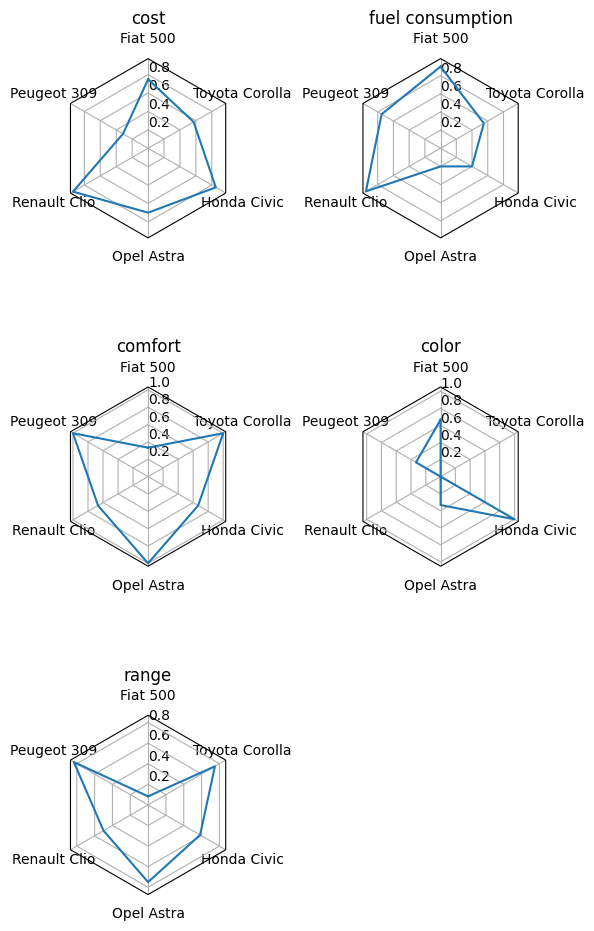

In [13]:
create_radar_projection(len(alternatives), frame='polygon')

fig = Figure(ncols=2, figsize=(6, 10))
for i in criteria:
    values = normalized_table.criteria_values[i].data
    ax = fig.create_add_axis(
        projection=radar_projection_name(len(alternatives)))
    ax.title = i
    ax.add_plot(
        RadarPlot(
            alternatives,
            values
        )
    )
fig.draw()

### Sum as alternatives scores

If the user has no priority between the criteria, we can simply compute the score of each alternative by summing all its criteria values:

In [14]:
alternatives_values = normalized_table.sum(axis=1)
alternatives_values.data

Fiat 500          2.733333
Peugeot 309       3.230952
Renault Clio      3.059524
Opel Astra        2.983333
Honda Civic       3.500000
Toyota Corolla    2.871429
dtype: float64

We have a winner! Or at least a ranking that will inform the user for its choice.

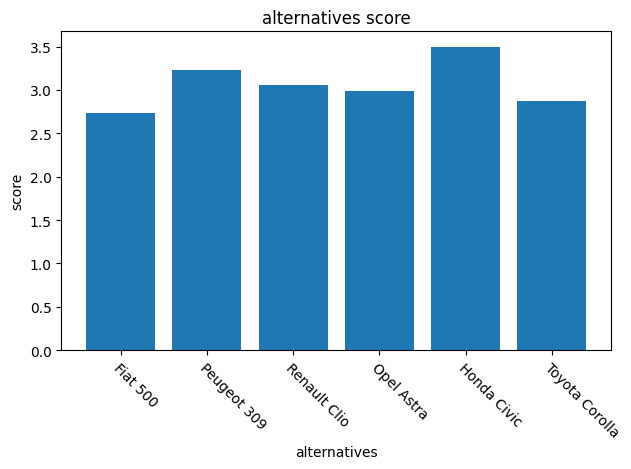

In [15]:
x = [*range(len(alternatives))]
plot = BarPlot(
    x, alternatives_values.data, xticks=x, 
    xticklabels=alternatives, xticklabels_tilted=True
)
plot.draw()
plot.axis.title = "alternatives score"
plot.axis.xlabel = "alternatives"
plot.axis.ylabel = "score"
plot.axis.figure.draw()

However, our user can also assign a different importance to each criterion.

### Weighted sum as alternatives scores

The simplest way to formalize different criteria importance, it to define a weight for each criterion.

Our user is really interested by range of its future car, comfort is also important, but the cost is not an issue:

In [16]:
from mcda.mavt.aggregators import WeightedSum

weighted_sum = WeightedSum({
    criteria[0]: 1,
    criteria[1]: 2,
    criteria[2]: 3,
    criteria[3]: 2,
    criteria[4]: 4
})

We can then multiply each normalized criterion value in the performance table by the corresponding criterion weight. We get the scores per alternative and criterion:

In [17]:
weighted_table = weighted_sum.weight_functions(normalized_table)
weighted_table.data

cost  fuel consumption  comfort     color     range
Fiat 500        0.750000               1.8      1.0  1.333333  0.333333
Peugeot 309     0.314286               1.5      3.0  0.666667  3.333333
Renault Clio    0.942857               1.9      2.0  0.000000  2.000000
Opel Astra      0.700000               0.4      3.0  0.666667  3.000000
Honda Civic     0.850000               0.8      2.0  2.000000  2.333333
Toyota Corolla  0.571429               1.1      3.0  0.000000  3.000000

We can visualize those scores, again using for example a spider plot:

/home/nduminy/pymcda/src/mcda/internal/plot/plot.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


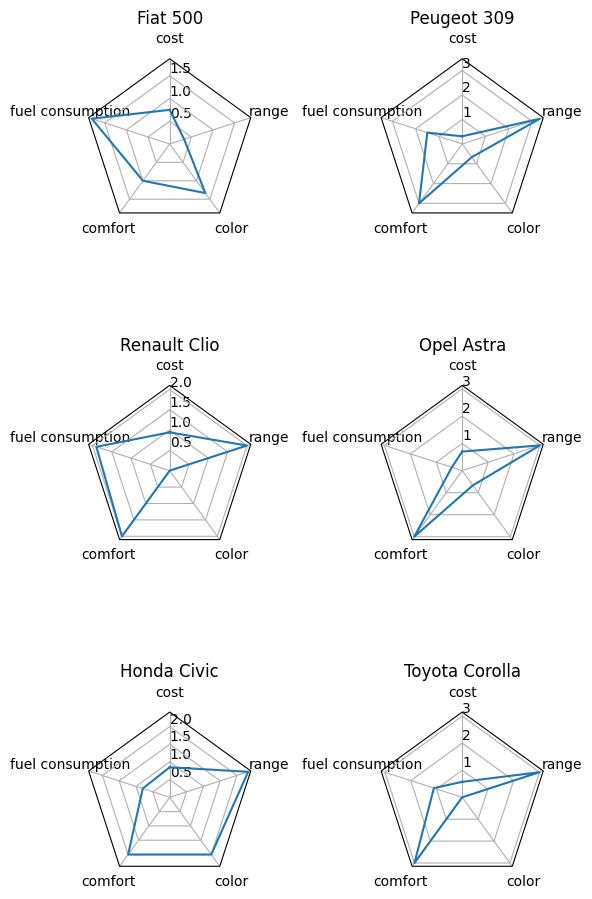

In [18]:
create_radar_projection(len(criteria), frame='polygon')

fig = Figure(ncols=2, figsize=(6, 10))
for i in alternatives:
    values = weighted_table.alternatives_values[i].data
    ax = fig.create_add_axis(
        projection=radar_projection_name(len(criteria)))
    ax.title = i
    ax.add_plot(
        RadarPlot(
            criteria,
            values
        )
    )
fig.draw()

If we compute the alternatives global scores, we get a different ranking:

In [19]:
alternatives_values = weighted_table.sum(axis=1)
alternatives_values.data

Fiat 500          5.216667
Peugeot 309       8.814286
Renault Clio      6.842857
Opel Astra        7.766667
Honda Civic       7.983333
Toyota Corolla    7.671429
dtype: float64

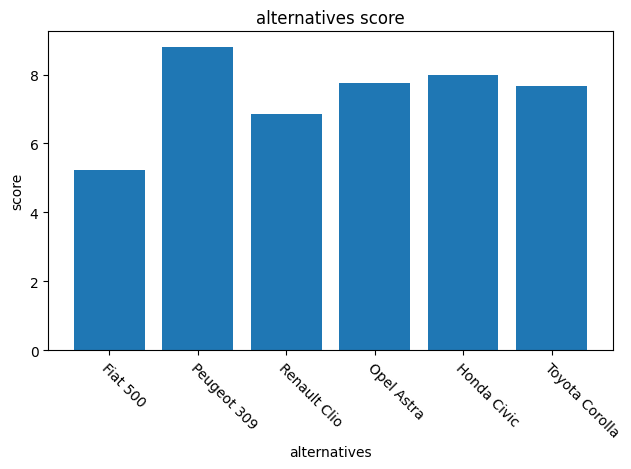

In [20]:
x = [*range(len(alternatives))]
plot = BarPlot(
    x, alternatives_values.data, xticks=x,
    xticklabels=alternatives, xticklabels_tilted=True
)
plot.draw()
plot.axis.title = "alternatives score"
plot.axis.xlabel = "alternatives"
plot.axis.ylabel = "score"
plot.axis.figure.draw()